<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

In [1]:
# READING SOME OF THE USEFUL PACKAGES 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TO EXTRACT SOME MORE ADVANCED FEATURES AND ANALYSIZE MORE IN DETAIL
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# nltk.download('punkt')   Package punkt is already up-to-date!
# nltk.download("stopwords")    Package stopwords is already up-to-date!

from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')  Package wordnet is already up-to-date!

# for visualizaton stuff
from wordcloud import WordCloud,STOPWORDS

# IMPORT FUZZYWUZZY
from fuzzywuzzy import fuzz

# for visualizaton stuff
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
# READING THE DATA
Qd = pd.read_csv(r"Z:\DS DATA\train.csv")
Qd.head()

import time
start_time =time.clock()

print(time.clock()-start_time,"seconds")

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
Qd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h3>Distribution of Data</h3>

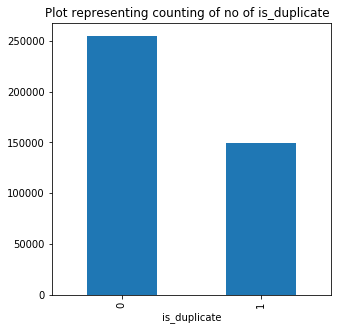

In [4]:
# RATION OF THE DUPLICATE AND NON DUPLICATE QUESTION
Qd['is_duplicate'].value_counts()
plt.figure(figsize=(5,5))
plt.title ("Plot representing counting of no of is_duplicate  ")
Qd.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [5]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(
    100 - round(Qd['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(
    round(Qd['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h2>Some basic Analysis on the Bases of qid1 and qid2</h2>

In [6]:
Qids = pd.Series(Qd['qid1'].tolist()+Qd['qid2'].tolist())

In [7]:
print("Total number of question are:",len(Qids),'\n')
print("Total number of question which are unique are: {}".format(len(Qids.unique())),'\n')
print("Total number of question which Occure more than one times: {} : ({}%)".format(
    np.sum(Qids.value_counts()>1),
    np.sum(Qids.value_counts()>1)/len(Qids.unique())*100),'\n')
print("Heighest a question occured is:",max(Qids.value_counts()))


Total number of question are: 808580 

Total number of question which are unique are: 537933 

Total number of question which Occure more than one times: 111780 : (20.77953945937505%) 

Heighest a question occured is: 157


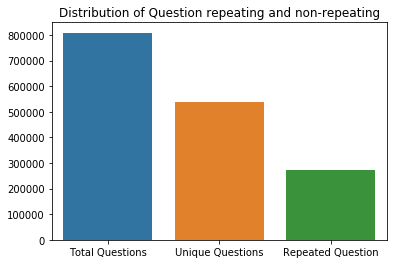

In [8]:
x=["Total Questions","Unique Questions","Repeated Question"]
y=[len(Qids),len(Qids.unique()),len(Qids)-len(Qids.unique())]
plt.title("Distribution of Question repeating and non-repeating")
sns.barplot(x,y)
plt.show()

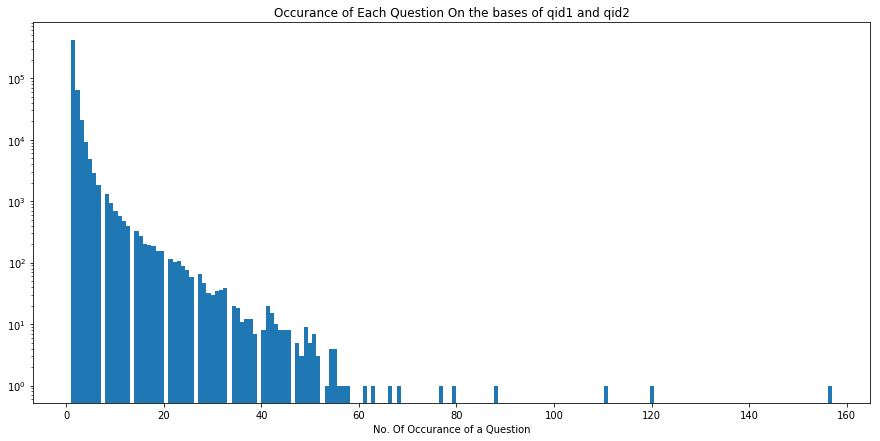

157 is the Maximum a single Question has been Repeated


In [9]:
plt.figure(figsize=(15,7))
plt.hist(Qids.value_counts(),bins=180)
plt.yscale('log', nonposy='clip')
plt.xlabel('No. Of Occurance of a Question')
plt.title("Occurance of Each Question On the bases of qid1 and qid2")
plt.show()
print("{} is the Maximum a single Question has been Repeated".format(max(Qids.value_counts())))

In [10]:
Qd['question1']=Qd['question1'].apply(lambda x: str(x).lower())

Qd['question2']=Qd['question2'].apply(lambda x: str(x).lower())

<h2>Some basic Feature Extraction</h2>
    <p>
    <b>Freq_qid1:----></b> Frequency(count) of Each question id in qid1<br>
    <b>Freq_qid2:----></b> Frequency(count) of Each question id in qid2<br>
    <b>q1_alph_len:----></b> No. of Alphabits in the Question 1 <br>
    <b>q2_alph_len:----></b> No. of Alphabits in the Question 2 <br>
    <b>q1_n_words:----></b> No. of words in the Question 1 <br>
    <b>q2_n_words:----></b> No. of words in the Question 2 <br>
    <b>total_words:----></b> No. of words in the Question 1 + Question 2<br>
    <b>q1_union_q2:----></b>length of union of words in Qustion1 and in Question2<br>
    <b>q1_intersec_q2:----></b>Length of Intersection of words in Qustion1 and in Question2<br>
    <b>fq1_pls_fq2:----></b>Sum of frequences of question 1 and question 2<br>
    <b>fq1_diff_fq2:----></b>difference of frequences of question 1 and question 2<br>
    <b>inter_union:----></b>Intersection of Q1 and Q1 is divided by Union of Q1 and Q2<br>
    </p>

In [11]:
# Frequency of qid1 and qid2 in 
Qd['freq_qid1'] = Qd.groupby(Qd["qid1"])["qid1"].transform("count")
Qd['freq_qid2'] = Qd.groupby(Qd["qid2"])["qid2"].transform("count")

Qd["q1_total_words"] = Qd['question1'].apply(lambda row: 0 if(type(row)==float or type(row)==None) else len(row.split(" ")))
Qd["q2_total_words"] = Qd['question2'].apply(lambda row: 0 if(type(row)==float or type(row)==None) else len(row.split(" ")))

# counts of word in each Questions (unique)
Qd['q1_n_words'] = Qd["question1"].apply(lambda x: len(set(x.split())))
Qd['q2_n_words'] = Qd["question2"].apply(lambda x: len(set(x.split())))

# Union of Question 1 and Question 2
Qd["q1_union_q2"] = Qd.apply(lambda row: (len(set(row['question1'].split(" ")).union(
    set(row['question2'].split(" "))))),axis=1)

# Intersection of Question 1 and Question 2
Qd["q1_q2_word_share"] = Qd.apply(lambda w: len(
    set(str(w['question1']).split(" ")) & set(str(w['question2']).split(" "))
),axis=1)

#total number of words in
Qd["total_words"] = Qd.apply(lambda w: (len(set(w["question1"].split())) + len(set(w["question2"].split()))),axis=1)

#Words share of Intersectioned words outof Union words of Q1 and Q2
Qd['word_share']= (Qd["q1_q2_word_share"]/Qd["total_words"])*1.0


# Intersection Divided by Union of Words----
Qd["intr_by_union"] = (Qd["q1_q2_word_share"]/Qd["q1_union_q2"])*1.0


# sum of Frequency of Q1 and Q2
Qd["fq1_pls_fq2"] = Qd['freq_qid1']+Qd['freq_qid2']

# Difference of Frequency of Q1 and Q2
Qd["fq1_diff_fq2"] = abs(Qd['freq_qid1']-Qd['freq_qid2'])


In [12]:
# OUR NEW CREATED FEATURES TILL NOW
Qd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                404290 non-null  int64  
 1   qid1              404290 non-null  int64  
 2   qid2              404290 non-null  int64  
 3   question1         404290 non-null  object 
 4   question2         404290 non-null  object 
 5   is_duplicate      404290 non-null  int64  
 6   freq_qid1         404290 non-null  int64  
 7   freq_qid2         404290 non-null  int64  
 8   q1_total_words    404290 non-null  int64  
 9   q2_total_words    404290 non-null  int64  
 10  q1_n_words        404290 non-null  int64  
 11  q2_n_words        404290 non-null  int64  
 12  q1_union_q2       404290 non-null  int64  
 13  q1_q2_word_share  404290 non-null  int64  
 14  total_words       404290 non-null  int64  
 15  word_share        404290 non-null  float64
 16  intr_by_union     40

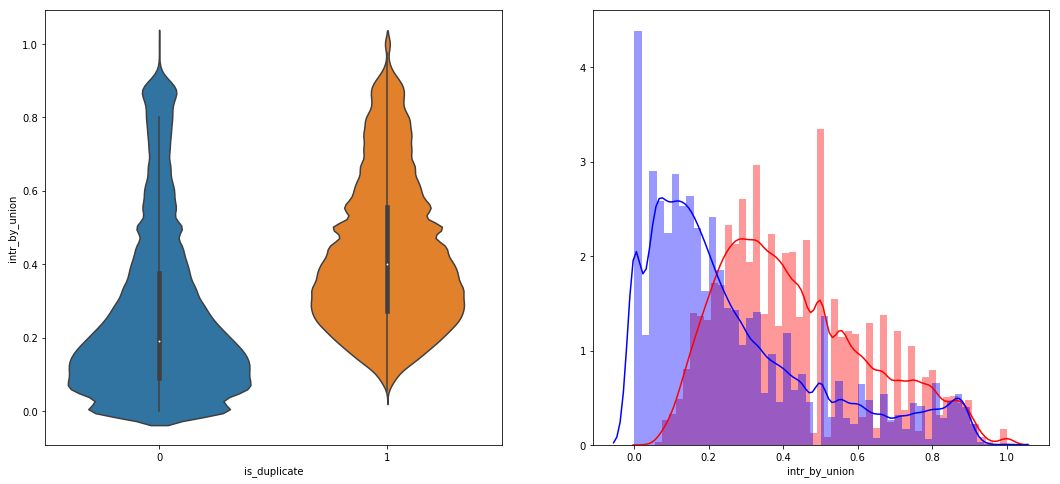

In [13]:
plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'intr_by_union', data = Qd[0:])

plt.subplot(1,2,2)
sns.distplot(Qd[Qd['is_duplicate'] == 1.0]['intr_by_union'][0:] , label = "1", color = 'red')
sns.distplot(Qd[Qd['is_duplicate'] == 0.0]['intr_by_union'][0:] , label = "0" , color = 'blue' )
plt.show()

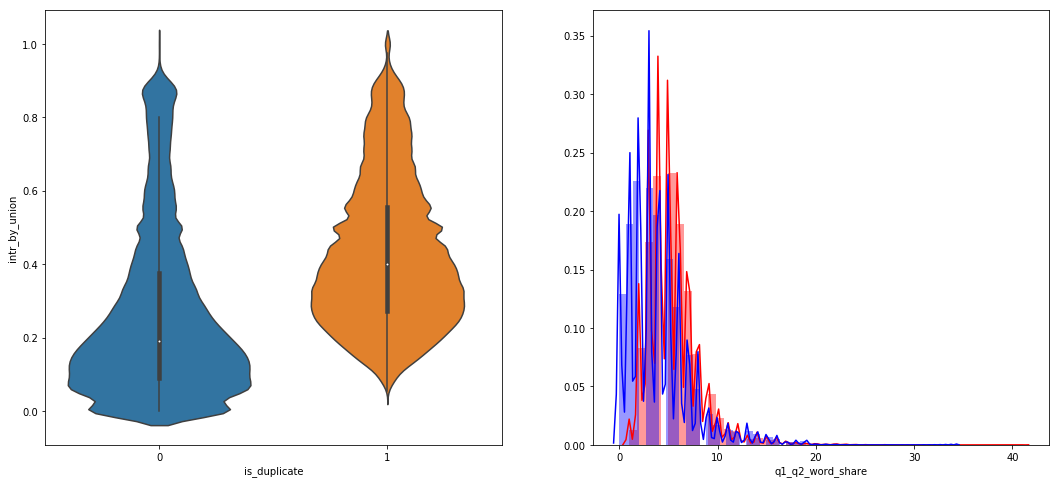

In [14]:
plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'intr_by_union', data = Qd[0:])

plt.subplot(1,2,2)
sns.distplot(Qd[Qd['is_duplicate'] == 1.0]['q1_q2_word_share'][0:] , label = "1", color = 'red')
sns.distplot(Qd[Qd['is_duplicate'] == 0.0]['q1_q2_word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

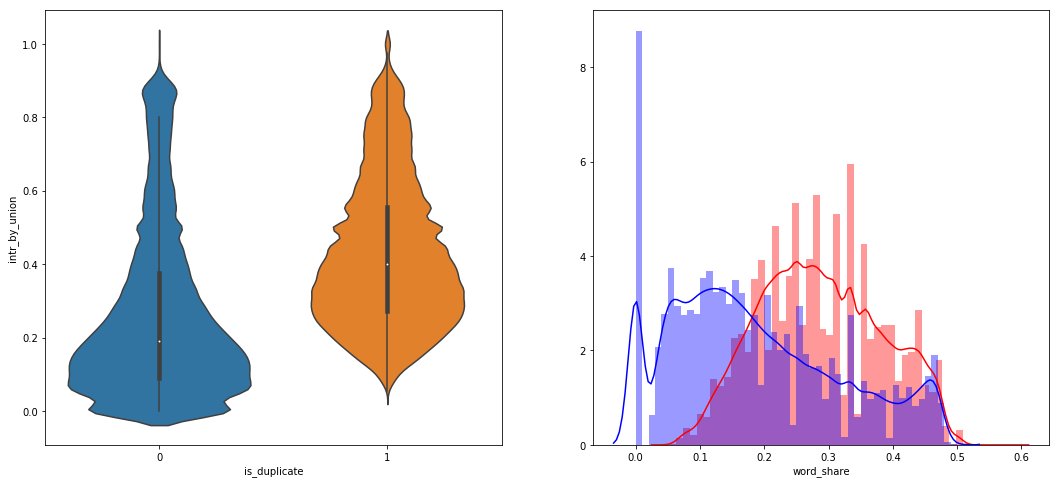

In [15]:
plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'intr_by_union', data = Qd[0:])

plt.subplot(1,2,2)
sns.distplot(Qd[Qd['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(Qd[Qd['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<p>
from this it is clear that not all but these features which i created are useful.
    As they are not seperating text completely but to some extend there is some value that can be useful to classifiy
</p>

<h1>Some Simple text cleaning</h1>

<h3>Preprocessing the Text</h3>
<p><b>-Preprocessing</b>:
    <ul style="trangle">
        <li>Removing Html tags</li>
        <li>Removing Punchutations</li>
        <li>Performing Stemming</li>
        <li>Removing Stopwords</li>
        <li>Expanding contraction etc...</li>
    </ul>
</p>

In [16]:
LEMATIZE = WordNetLemmatizer()
STOP_WORDS=stopwords.words("english")

In [17]:

def lematize(x):
    token=word_tokenize(x)
    lema = [LEMATIZE.lemmatize(word) for word in token ]
    y=" ".join(lema)
    return y

Qd['question1']= Qd["question1"].apply(lematize)
Qd["question2"]=Qd["question2"].apply(lematize)


In [18]:

def pre_process(x):
    #token=word_tokenize(x)
    #lema = [LEMATIZE.lemmatize(word) for word in token ]
    x=re.sub("  *"," ",re.sub("<.*?>"," ",str(x))) #for removing html tages
    
#     x=re.sub("  *"," ",re.sub('<[a-zA-Z]*>|</[a-zA-Z]*>',' ',str(x))).lower()
    x=x.replace("%","percent").replace("$","dollar").replace("₹","rupees").replace("rs","rupees").replace(
    "i'm","i am").replace("don't","do not").replace("&","and").replace("we're","we are").replace(
        "you're","you are").replace("they're","they are").replace("he's","he is").replace(
        "have't","have not").replace("has't","has not").replace("is't","is not").replace(
        "didn't","did not").replace("he'll","he will").replace("she'll","she will").replace(
        "it'll","it will").replace(',000',"k").replace("000,000","m").replace(
        "'ve","have").replace('000',"k").replace("000000","m").replace('(',"").replace(
        ')',"").replace("€",'euro').replace("?",'').replace("`",'')
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    x=re.sub("[^a-z0-9-]"," ",x)

    return  x
        
Qd["question1"] = Qd["question1"].apply(pre_process)
Qd["question2"] = Qd["question2"].apply(pre_process)


In [19]:
def fill_emptly(x):
    if len(str(x['question1']))<=6:
        x['question1']=""
    if len(str(x['question2']))<=6:
        x['question2']=""
    if x["is_duplicate"]==0 and (x['question1']=="  " or x['question2']=="  "):
        x['is_duplicate']=1
        
    if x['question1']==" " or x['question2']==" ":
        print("yes")
    return x

Qd = Qd.apply(fill_emptly,axis=1)

<h3>Important Terms</h3><br>
<b>-Token-: </b>Each word after splitting the sentence is token<br>
<b>-Stop_Word-: </b>Stops word that are in nltk<br>
<b>-Words-: </b>token that is not in stopwords<br>
<h2>Feature Extraction </h2><br>
<h4>These are some extra and advanced features </h4><br>

<b>Commom_word_Count_Min (cwc_min) </b>length of Intersection of Q1 and Q2 divide by Minimum length of Q1 and Q2 word<br>
<b>Commom_word_Count_Max (cwc_max) </b>length Intersection of Q1 and Q2 divide by Maximum length of Q1 and Q2 words<br>
<b>Commom_StopWord_Count_min (csc_min) </b>length Intersection of Q1 and Q2 divide by Minimum length of Q1 and Q2 stopwords<br>
<b>Commom_StopWord_Count_Max (cwc_max) </b>length Intersection of Q1 and Q2 divide by Maximum length of Q1 and Q2 stopwords<br>
<b>Commom_Token_Count_Min (ctc_min) </b>length Intersection of Q1 and Q2 divide by Minimum length of Q1 and Q2 tokenwords<br>
<b>Commom_Token_Count_Max (ctc_max) </b>length Intersection of Q1 and Q2 divide by Maximum length of Q1 and Q2 tokenwords<br>
<b>First_token_Common (fw_com ) </b>checking common token in both Questions at first place<br>
<b>Last_token_Common (lw_com) </b>checking common token in both Questions at last place<br>
<b>Absolute difference(abs_diff) </b>Absolute difference b/w length of Q1 and Q2 token<br>
<b>Middle of both question (ratio) </b>middle value of both(Q1+Q2) question<br>

In [20]:
# computing common_word_count_min cwc_min
SAFE_DIV = 0.0001
def extract_features(x):
    
    global SAFE_DIV
    q1_token=word_tokenize(x["question1"])
    q2_token=word_tokenize(x["question2"])
    
    q1_words = set([word for word in q1_token if word not in STOP_WORDS])
    q2_words = set([word for word in q2_token if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_token if word in STOP_WORDS])
    q2_stops = set([word for word in q2_token if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_token).intersection(set(q2_token)))
    
    cwc_min=0
    cwc_max=0
#     MIN MAX FOR WORDS
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)  # MAX
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV) # MIN

#     MIN MAX FOR STOP WORDS
    csc_min=0
    csc_max=0
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)  # MAX
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV) # MIN
    
#     MIN MAX FOR TOKENS
    ctc_min=0
    ctc_max=0
    ctc_max = common_token_count / (max(len(q1_token), len(q2_token)) + SAFE_DIV)  # MAX
    ctc_min = common_token_count / (min(len(q1_token), len(q2_token)) + SAFE_DIV) # MIN

#     LAST WORD FIRST WORD DIFF. LAST WORD DIFF. ABSOLUTE DIFF. RATION B/W TOKENS
    if len(q1_token)<=0 or len(q2_token)<=0:
        fw_com =0
        lw_com =0
    else:
        fw_com = int(q1_token[0]==q2_token[0])
        lw_com = int(q1_token[-1]==q2_token[-1])
    abs_diff= abs(len(q1_token)-len(q2_token))
    ratio = (len(q1_token)+len(q2_token)) / 2
    
    return cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, fw_com, lw_com, abs_diff, ratio
    
Qd[["cwc_min","cwc_max","csc_min","csc_max","ctc_min",
    "ctc_max","fw_com","lw_com","abs_diff","ratio"]] = Qd.apply(extract_features,axis=1,result_type="expand")


In [21]:
def fuzzyfeatures(x):
    token_set_ratio = fuzz.token_set_ratio(x["question1"],x["question2"])
    token_sort_ratio = fuzz.token_sort_ratio(x["question1"],x["question2"])
    fuzz_ratio = fuzz.QRatio (x["question1"],x["question2"])
    partial_ratio = fuzz.partial_ratio(x["question1"],x["question2"])

    return token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio

Qd[["token_set_ratio","token_sort_ratio",
    "fuzz_ratio","partial_ratio"]]=Qd.apply(fuzzyfeatures,axis=1,result_type='expand')


In [22]:
Qd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                404290 non-null  int64  
 1   qid1              404290 non-null  int64  
 2   qid2              404290 non-null  int64  
 3   question1         404290 non-null  object 
 4   question2         404290 non-null  object 
 5   is_duplicate      404290 non-null  int64  
 6   freq_qid1         404290 non-null  int64  
 7   freq_qid2         404290 non-null  int64  
 8   q1_total_words    404290 non-null  int64  
 9   q2_total_words    404290 non-null  int64  
 10  q1_n_words        404290 non-null  int64  
 11  q2_n_words        404290 non-null  int64  
 12  q1_union_q2       404290 non-null  int64  
 13  q1_q2_word_share  404290 non-null  int64  
 14  total_words       404290 non-null  int64  
 15  word_share        404290 non-null  float64
 16  intr_by_union     40

<h2>Some extra visualization to gain some more insights</h2>

In [23]:
df_duplicate = Qd[Qd['is_duplicate']==1]
df_noduplicate = Qd[Qd['is_duplicate']==0]

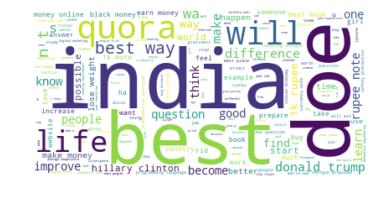

In [24]:
q1=np.dstack([df_duplicate["question1"],df_duplicate["question2"]]).flatten()
wordcloud_spam = WordCloud(background_color="white").generate(" ".join(q1))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()


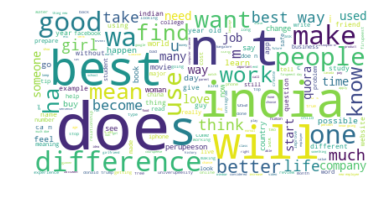

In [25]:
q1=np.dstack([df_noduplicate["question1"],df_noduplicate["question2"]]).flatten()
wordcloud_spam = WordCloud(background_color="white").generate(" ".join(q1))
# # Lines 2 - 5
# plt.figure(figsize = (10,10))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()


In [26]:

dfp_subsampled = Qd[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' ,
                                                 'ctc_max' , 'fw_com', 'lw_com' , 'abs_diff' , 'ratio' ,
                                                 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' ,
                                                 'partial_ratio' ]])
y = dfp_subsampled['is_duplicate'].values


In [27]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

C:\Users\Danish\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.100s...
[t-SNE] Computed neighbors for 5000 samples in 0.394s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.120571
[t-SNE] Computed conditional probabilities in 0.286s
[t-SNE] Iteration 50: error = 81.7079849, gradient norm = 0.0430054 (50 iterations in 3.205s)
[t-SNE] Iteration 100: error = 70.5109253, gradient norm = 0.0095824 (50 iterations in 2.013s)
[t-SNE] Iteration 150: error = 68.2919540, gradient norm = 0.0066872 (50 iterations in 2.123s)
[t-SNE] Iteration 200: error = 67.2939301, gradient norm = 0.0043061 (50 iterations in 2.010s)
[t-SNE] Iteration 250: error = 66.7245789, gradient norm = 0.0036136

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


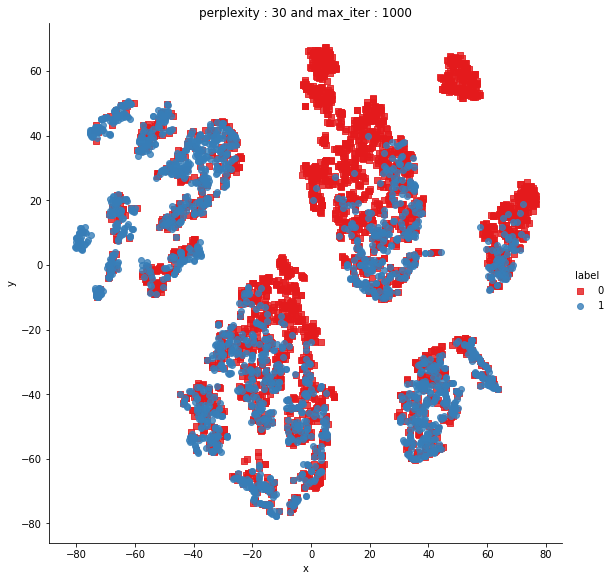

In [28]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [29]:
# Qd.to_csv(r"Z:\DS DATA\feature_train.csv",index=False)
Qd.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_total_words,q2_total_words,...,ctc_min,ctc_max,fw_com,lw_com,abs_diff,ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,14,12,...,0.916659,0.785709,1.0,0.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh-i-noor dia...,what would happen if the indian government sto...,0,4,1,8,13,...,0.624992,0.384612,1.0,0.0,5.0,10.5,86,63,66,75
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,14,10,...,0.399996,0.285712,1.0,0.0,4.0,12.0,63,63,43,47
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 ...,0,1,1,11,9,...,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,8,14
4,4,9,10,which one dissolve in water quikly sugar sal...,which fish would survive in salt water,0,3,1,13,7,...,0.571420,0.307690,1.0,0.0,6.0,10.0,67,47,35,56


In [40]:
# def preprocess(x):    
# #     x=re.sub("[^a-zA-Z0-9]",' ',str(x).lower())
#     x=x.replace("€",'euro').replace("%","percent").replace("$",'dollar').replace("   "," ").replace(
#         "  "," ").replace("₹","rupee").replace("ll",'will').replace("&","and").replace(',000','k').replace(
#         '00,000','l').replace('000,000','m').replace("don't",'do not').replace("would't",'would not').replace(
#         "can't",'can not').replace("cannot",'can not').replace("it's",'it is').replace("hv",'have').replace(
#         "have't",'have not').replace("she's",'she is').replace("he's",'he is').replace("won't",'will not').replace(
#         "i'm",'i am')
#     return x
# Qd['question1']=Qd['question1'].apply(preprocess)
# Qd['question2']=Qd['question2'].apply(preprocess)
# # Qd.head()